In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from joblib import dump

#import warnings
#warnings.filterwarnings("ignore")

### Functions

In [2]:
def load_data(file_name):
    """ Load data by file name """
    
    file_path = os.path.join(path, file_name)
    data = pd.read_csv(file_path, index_col=0, parse_dates=True)
    data.sort_index(inplace=True)
    return data


def timestamp_features(data):
    """ Create new features based on the timestamp index """
    data.index = pd.to_datetime(data.index, format="%d/%m/%Y")


    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day


    return data


def plot_time_series(data, target_column):
    """ Plot time series data for a specific target column """
    plt.figure(figsize=(14, 7))
    sns.lineplot(x=data.index, y=data[target_column])
    plt.title(f'Time Series Plot of {target_column}')
    plt.xlabel('Date')
    plt.ylabel(target_column)
    plt.show()


def plot_corr_matrix(data):
    """ Plot the correlation matrix of all features """
    
    corr = data.corr()
    return corr.style.background_gradient(cmap='coolwarm', axis=None).format(precision=2)



def scale_data(data, targets):
    """ Z-score Normalization of feature data """
    
    features_to_scale = data.columns.difference(targets)

    scaler = StandardScaler()

    data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

    return data



def create_train_and_test(data, targets, target, by_value=None):
    """ Create train and test data for modeling and prediction """
    
    if by_value is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            data[data.columns.difference(targets)],
            data[target],
            test_size=by_value,
            random_state=42  
        )
    else:
        X_train, X_test, y_train, y_test = train_test_split(
            data[data.columns.difference(targets)],
            data[target],
            test_size=0.2,  
            stratify=data[target].notnull(),   
            random_state=42
        )
    return X_train, y_train, X_test, y_test


def get_best_model_and_accuracy(model, params, X, y):
    """ GridSearch for given model and parameters """
    
    grid = GridSearchCV(model, params,
                        error_score=0.,
                        scoring='neg_root_mean_squared_error')
    grid.fit(X, y)
    
    score = -grid.best_score_
    time_fit = grid.cv_results_['mean_fit_time'].mean()
    time_score = grid.cv_results_['mean_score_time'].mean()
    best_params = grid.best_params_
    
    print('Best score:', score)
    print('Best params:', best_params)
    print('Average Time (Fit)', round(time_fit, 3))
    print('Average Time (Score)', round(time_score, 3))
    
    return [score, time_fit, time_score, best_params]


def label_missing_values(s):
    """ Label missing values (=0) with None """
    if s == 0:
        return None
    else:
        return s


def plot_compare_before_after(data, y_test, target):
    """Compare target before and after prediction."""
    
    fig, axs = plt.subplots(1, 2, figsize=(18, 4))
    fig.subplots_adjust(hspace=0.5, wspace=0.2)
    axs = axs.ravel()
    x = data.index
    
    axs[0] = sns.lineplot(x=x, y=data[target], label='original', ax=axs[0])
    axs[0].grid()
    axs[0].set_xlabel('date')
    axs[0].set_title('Before')

    axs[1] = sns.lineplot(x=x, y=data[target], label='original', ax=axs[1])
    axs[1] = sns.lineplot(x=y_test.index, y=y_test, label='prediction', alpha=0.7, ax=axs[1])
    axs[1].grid()
    axs[1].set_xlabel('date')
    axs[1].set_title('After')

    plt.show()

In [3]:
import os
import pandas as pd

path = r'C:\Users\Rashid\Documents\my_projects\4geeks\time-series-project\data\raw'

files = os.listdir(path)

print("List of Files:", files)

compare = pd.DataFrame(index=files, columns=['samples', 'features', 'features_with_nan'])

for file in files:
    if file.endswith('.csv'):
        data = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)
        data.sort_index(inplace=True)

        compare.loc[file, 'samples'] = len(data.index)
        compare.loc[file, 'features'] = len(data.columns)
        counter = sum(data[col].isnull().sum() > 0 for col in data.columns)
        compare.loc[file, 'features_with_nan'] = counter

print("\nComparison DataFrame:")
print(compare)



List of Files: ['.gitkeep', 'Aquifer_Auser.csv', 'Aquifer_Doganella.csv', 'Aquifer_Luco.csv', 'Aquifer_Petrignano.csv', 'datasets_description.ods', 'datasets_description.xlsx', 'Lake_Bilancino.csv', 'River_Arno.csv', 'Water_Spring_Amiata.csv', 'Water_Spring_Lupa.csv', 'Water_Spring_Madonna_di_Canneto.csv']


C:\Users\Rashid\AppData\Local\Temp\ipykernel_13860\2362351142.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv(os.path.join(path, file), index_col=0, parse_dates=True)



Comparison DataFrame:
                                    samples features features_with_nan
.gitkeep                                NaN      NaN               NaN
Aquifer_Auser.csv                      8154       26                22
Aquifer_Doganella.csv                  6026       21                21
Aquifer_Luco.csv                       7487       21                17
Aquifer_Petrignano.csv                 5223        7                 7
datasets_description.ods                NaN      NaN               NaN
datasets_description.xlsx               NaN      NaN               NaN
Lake_Bilancino.csv                     6603        8                 7
River_Arno.csv                         8217       16                16
Water_Spring_Amiata.csv                7487       15                14
Water_Spring_Lupa.csv                  4199        2                 1
Water_Spring_Madonna_di_Canneto.csv    3113        3                 3


In [4]:
import os
import pandas as pd

path = r'C:\Users\Rashid\Documents\my_projects\4geeks\time-series-project\data\raw'

files = os.listdir(path)

print("List of Files:", files)

targets = {
    'Aquifer_Doganella': [
        'Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3',
        'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6',
        'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'
    ],
    'Aquifer_Auser': ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2'],
    'Water_Spring_Amiata': ['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'],
    'Lake_Bilancino': ['Lake_Level', 'Flow_Rate'],
    'Water_Spring_Madonna_di_Canneto': ['Flow_Rate_Madonna_di_Canneto'],
    'Aquifer_Luco': ['Depth_to_Groundwater_Podere_Casetta'],
    'Aquifer_Petrignano': ['Depth_to_Groundwater_P24', 'Depth_to_Groundwater_P25'],
    'Water_Spring_Lupa': ['Flow_Rate_Lupa'],
    'River_Arno': ['Hydrometry_Nave_di_Rosano']
}

print("\nTargets Dictionary:")
print(targets)



List of Files: ['.gitkeep', 'Aquifer_Auser.csv', 'Aquifer_Doganella.csv', 'Aquifer_Luco.csv', 'Aquifer_Petrignano.csv', 'datasets_description.ods', 'datasets_description.xlsx', 'Lake_Bilancino.csv', 'River_Arno.csv', 'Water_Spring_Amiata.csv', 'Water_Spring_Lupa.csv', 'Water_Spring_Madonna_di_Canneto.csv']

Targets Dictionary:
{'Aquifer_Doganella': ['Depth_to_Groundwater_Pozzo_1', 'Depth_to_Groundwater_Pozzo_2', 'Depth_to_Groundwater_Pozzo_3', 'Depth_to_Groundwater_Pozzo_4', 'Depth_to_Groundwater_Pozzo_5', 'Depth_to_Groundwater_Pozzo_6', 'Depth_to_Groundwater_Pozzo_7', 'Depth_to_Groundwater_Pozzo_8', 'Depth_to_Groundwater_Pozzo_9'], 'Aquifer_Auser': ['Depth_to_Groundwater_SAL', 'Depth_to_Groundwater_CoS', 'Depth_to_Groundwater_LT2'], 'Water_Spring_Amiata': ['Flow_Rate_Bugnano', 'Flow_Rate_Arbure', 'Flow_Rate_Ermicciolo', 'Flow_Rate_Galleria_Alta'], 'Lake_Bilancino': ['Lake_Level', 'Flow_Rate'], 'Water_Spring_Madonna_di_Canneto': ['Flow_Rate_Madonna_di_Canneto'], 'Aquifer_Luco': ['Depth

In [5]:
river_arno = load_data('River_Arno.csv')

In [6]:
river_arno_time = timestamp_features(river_arno)

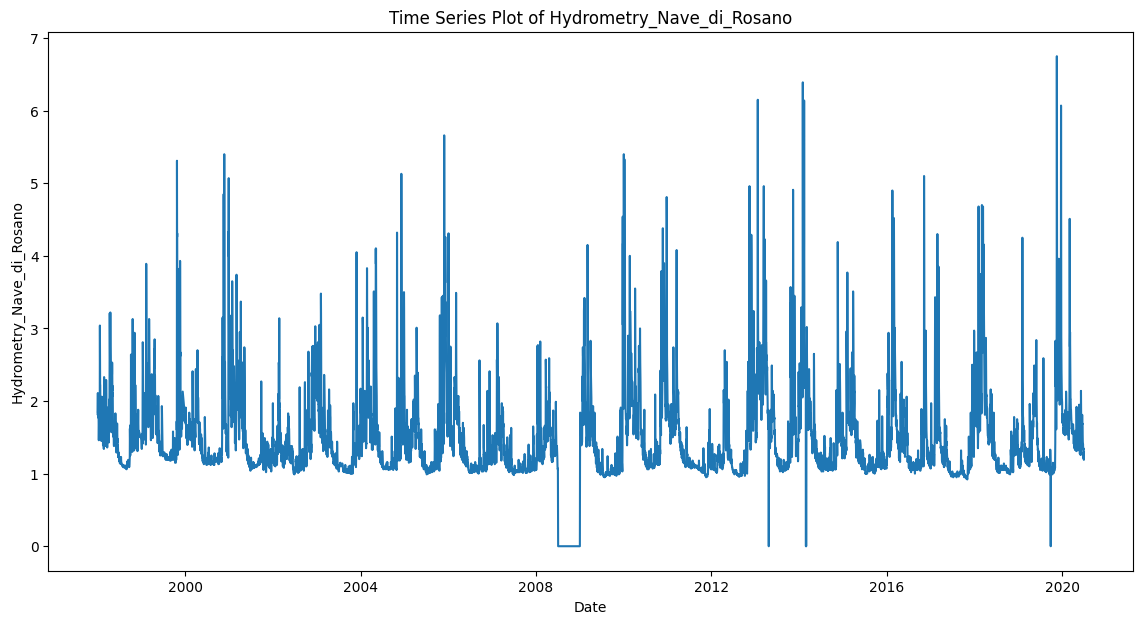

In [7]:
plot_time_series(river_arno, targets['River_Arno'][0])


In [8]:
river_arno[river_arno[targets['River_Arno']]==0].head()


,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano,year,month,day
Date,,,,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
plot_corr_matrix(river_arno)

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano,year,month,day
Rainfall_Le_Croci,1.00,0.92,0.88,0.86,0.91,0.79,0.37,0.34,0.44,0.35,0.31,0.31,0.43,0.30,-0.13,0.24,0.01,0.02,-0.03
Rainfall_Cavallina,0.92,1.00,0.89,0.87,0.91,0.81,0.35,0.33,0.42,0.35,0.31,0.31,0.44,0.29,-0.12,0.22,0.02,0.04,-0.01
Rainfall_S_Agata,0.88,0.89,1.00,0.87,0.90,0.79,0.42,0.38,0.45,0.38,0.36,0.35,0.45,0.34,-0.11,0.22,0.02,0.04,-0.02
Rainfall_Mangona,0.86,0.87,0.87,1.00,0.87,0.88,0.37,0.34,0.42,0.32,0.32,0.28,0.43,0.30,-0.12,0.23,0.02,0.03,-0.02
Rainfall_S_Piero,0.91,0.91,0.90,0.87,1.00,0.78,0.41,0.38,0.45,0.39,0.35,0.34,0.47,0.33,-0.11,0.21,0.02,0.04,-0.02
Rainfall_Vernio,0.79,0.81,0.79,0.88,0.78,1.00,0.33,0.32,0.38,0.30,0.29,0.26,0.36,0.27,-0.12,0.24,0.02,0.03,0.00
Rainfall_Stia,0.37,0.35,0.42,0.37,0.41,0.33,1.00,0.82,0.80,0.75,0.68,0.72,0.85,0.76,-0.11,0.46,-0.05,0.08,0.02
Rainfall_Consuma,0.34,0.33,0.38,0.34,0.38,0.32,0.82,1.00,0.81,0.74,0.62,0.72,0.77,0.76,-0.10,0.47,-0.03,0.07,-0.01
Rainfall_Incisa,0.44,0.42,0.45,0.42,0.45,0.38,0.80,0.81,1.00,0.84,0.70,0.80,0.79,0.67,-0.10,0.35,0.02,0.04,-0.01
Rainfall_Montevarchi,0.35,0.35,0.38,0.32,0.39,0.30,0.75,0.74,0.84,1.00,0.80,0.87,0.79,0.65,-0.06,0.40,-0.04,0.07,0.01


In [10]:
date_from = '2005-01-01'
River_Arno = river_arno[date_from:]

In [11]:
# Fill missing values with col mean value
River_Arno[River_Arno.columns.difference(targets['River_Arno'])] = River_Arno[River_Arno.columns.difference(targets['River_Arno'])].fillna(River_Arno[River_Arno.columns.difference(targets['River_Arno'])].mean())
River_Arno[targets['River_Arno']] = River_Arno[targets['River_Arno']].fillna(0)

In [12]:
River_Arno = scale_data(River_Arno, targets['River_Arno'])


In [13]:
X_train, y_train, X_test, y_test = create_train_and_test(River_Arno,
                                                         targets['River_Arno'],
                                                         targets['River_Arno'][0],
                                                         by_value=None)

In [14]:
model_XGB = XGBRegressor(random_state=2020)
params_XGB = {'n_estimators': [5, 10, 50, 100],
              'max_depth': [1, 2, 3, 4, 5]} 
score, time_fit, time_score, best_params = get_best_model_and_accuracy(model_XGB, params_XGB,
                                                                       X_train, y_train)

Best score: 0.37701036194108006
Best params: {'max_depth': 5, 'n_estimators': 100}
Average Time (Fit) 0.714
Average Time (Score) 0.051


In [15]:
model_LR = LinearRegression()
params_LR = {}
score, time_fit, time_score, best_params = get_best_model_and_accuracy(model_LR, params_LR,
                                                                       X_train, y_train)

Best score: 0.5389565599642733
Best params: {}
Average Time (Fit) 0.065
Average Time (Score) 0.014


In [16]:
River_Arno[targets['River_Arno'][0]] = River_Arno[targets['River_Arno'][0]].apply(label_missing_values)

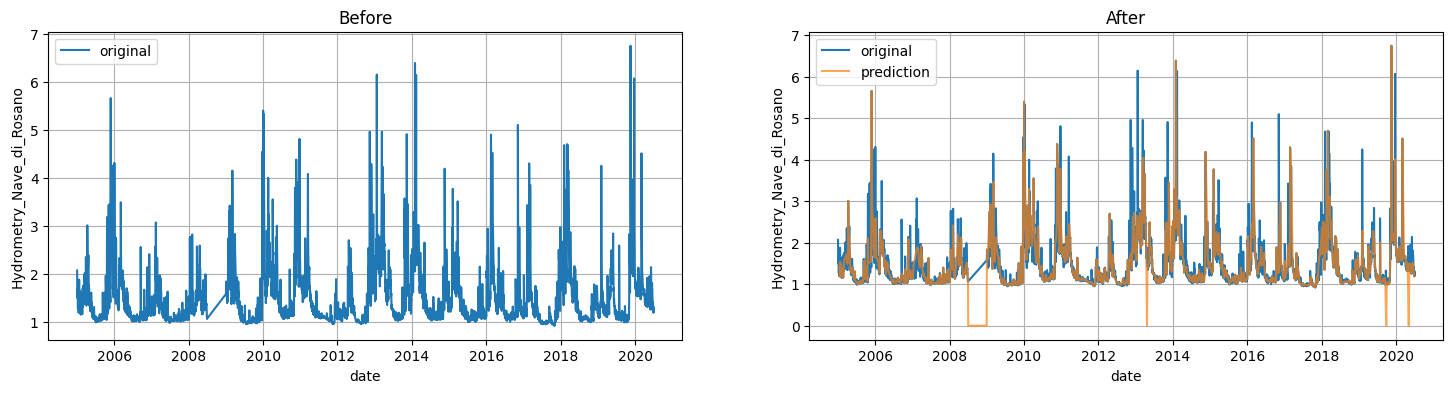

In [17]:
plot_compare_before_after(River_Arno, y_test, targets['River_Arno'][0])

### Aquifer_Luco

In [18]:
Aquifer_Luco = load_data('Aquifer_Luco.csv')
targets['Aquifer_Luco']

['Depth_to_Groundwater_Podere_Casetta']

In [19]:
River_Arno = timestamp_features(River_Arno)


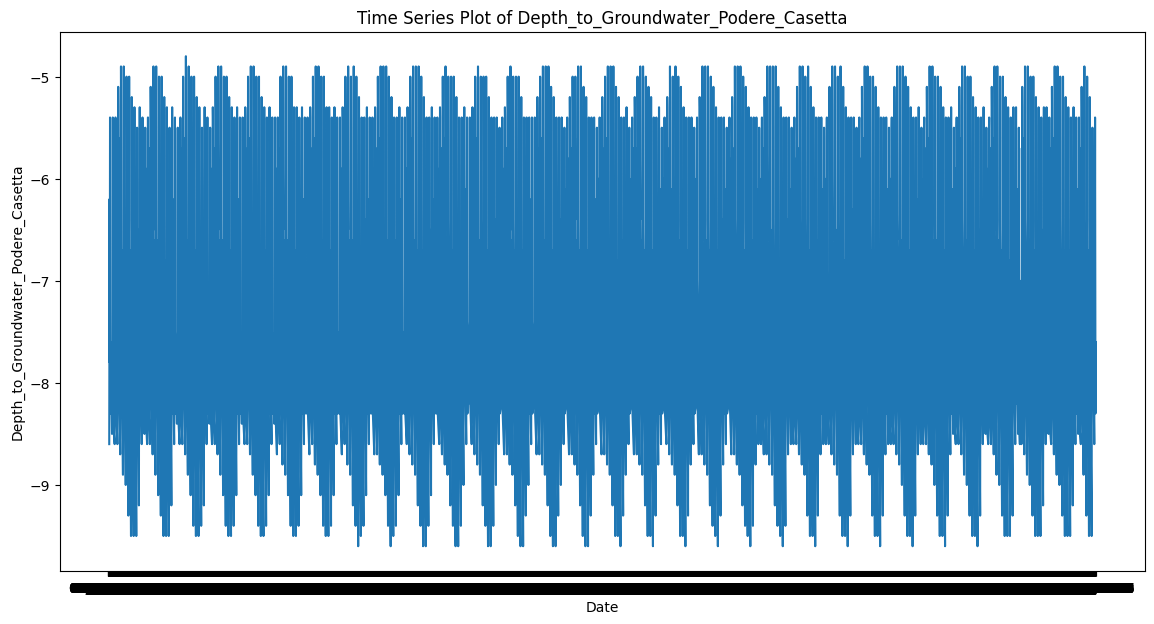

In [20]:
plot_time_series(Aquifer_Luco, targets['Aquifer_Luco'][0])

Fill missing features values by mean.

In [21]:
Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])] = Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].fillna(Aquifer_Luco[Aquifer_Luco.columns.difference(targets['Aquifer_Luco'])].mean())

In [22]:
#Aquifer_Luco = Aquifer_Luco.drop(columns=['Depth_to_Groundwater_Podere_Casetta'])

Aquifer_Luco.dropna(inplace=True)

In [23]:
plot_corr_matrix(Aquifer_Luco)

,Rainfall_Simignano,Rainfall_Siena_Poggio_al_Vento,Rainfall_Mensano,Rainfall_Montalcinello,Rainfall_Monticiano_la_Pineta,Rainfall_Sovicille,Rainfall_Ponte_Orgia,Rainfall_Scorgiano,Rainfall_Pentolina,Rainfall_Monteroni_Arbia_Biena,Depth_to_Groundwater_Podere_Casetta,Depth_to_Groundwater_Pozzo_1,Depth_to_Groundwater_Pozzo_3,Depth_to_Groundwater_Pozzo_4,Temperature_Siena_Poggio_al_Vento,Temperature_Mensano,Temperature_Pentolina,Temperature_Monteroni_Arbia_Biena,Volume_Pozzo_1,Volume_Pozzo_3,Volume_Pozzo_4
Rainfall_Simignano,1.00,0.30,0.23,0.63,0.38,0.70,0.35,0.15,0.04,0.40,-0.03,0.03,0.04,-0.02,0.01,-0.03,-0.13,-0.07,-0.01,0.00,-0.02
Rainfall_Siena_Poggio_al_Vento,0.30,1.00,0.27,0.25,0.35,0.27,0.64,0.07,0.05,0.24,-0.02,0.05,0.05,-0.05,-0.02,-0.02,-0.04,-0.02,-0.00,-0.03,-0.06
Rainfall_Mensano,0.23,0.27,1.00,0.23,0.17,0.19,0.27,0.07,0.02,0.12,-0.01,0.06,0.05,0.01,0.02,-0.03,-0.04,-0.02,-0.00,-0.00,-0.02
Rainfall_Montalcinello,0.63,0.25,0.23,1.00,0.34,0.73,0.29,0.14,0.07,0.41,-0.00,0.01,0.02,0.00,-0.01,-0.05,-0.14,-0.08,-0.01,0.01,-0.00
Rainfall_Monticiano_la_Pineta,0.38,0.35,0.17,0.34,1.00,0.38,0.45,0.15,0.04,0.62,0.01,0.01,0.01,-0.01,-0.00,-0.07,-0.04,-0.00,0.03,0.03,-0.00
Rainfall_Sovicille,0.70,0.27,0.19,0.73,0.38,1.00,0.31,0.16,0.08,0.59,0.01,0.02,0.03,-0.03,0.01,-0.02,-0.11,-0.05,0.00,0.01,-0.01
Rainfall_Ponte_Orgia,0.35,0.64,0.27,0.29,0.45,0.31,1.00,0.08,0.06,0.27,-0.01,0.04,0.04,-0.04,0.04,-0.04,-0.05,-0.01,-0.00,-0.00,-0.04
Rainfall_Scorgiano,0.15,0.07,0.07,0.14,0.15,0.16,0.08,1.00,0.02,0.20,0.06,0.00,-0.00,0.01,-0.02,-0.04,-0.08,0.01,0.01,0.02,0.03
Rainfall_Pentolina,0.04,0.05,0.02,0.07,0.04,0.08,0.06,0.02,1.00,0.08,0.00,-0.01,-0.03,0.02,-0.06,-0.08,-0.11,-0.11,0.03,0.04,0.06
Rainfall_Monteroni_Arbia_Biena,0.40,0.24,0.12,0.41,0.62,0.59,0.27,0.20,0.08,1.00,0.01,0.01,-0.01,0.01,-0.02,-0.07,-0.06,-0.01,0.01,0.03,0.01


In [24]:
Aquifer_Luco = scale_data(Aquifer_Luco, targets['Aquifer_Luco'])

In [25]:
X_train, y_train, X_test, y_test = create_train_and_test(Aquifer_Luco,
                                                         targets['Aquifer_Luco'],
                                                         targets['Aquifer_Luco'][0],
                                                         by_value=None)

In [26]:
model_XGB = XGBRegressor(random_state=2020)
params_XGB = {'n_estimators': [1000, 1500, 2000],
              'max_depth': [1, 2, 3, 4, 5]} 
score, time_fit, time_score, best_params_XGB = get_best_model_and_accuracy(model_XGB, params_XGB,
                                                                           X_train, y_train)

Best score: 0.7171127404033724
Best params: {'max_depth': 2, 'n_estimators': 1000}
Average Time (Fit) 6.095
Average Time (Score) 0.039


In [27]:
model_LR = LinearRegression()
params_LR = {}
score, time_fit, time_score, best_params = get_best_model_and_accuracy(model_LR, params_LR,
                                                                       X_train, y_train)

Best score: 0.9681765196549591
Best params: {}
Average Time (Fit) 0.014
Average Time (Score) 0.007
